In [1]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter
import re


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")

In [2]:
INFILE = '/Users/zachtsouprakos/documents/msds/msds-422/HMEQ_Loss.csv'

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

In [3]:
df = pd.read_csv(INFILE)
len(df)

5960

In [4]:
# Lets put all objects and integer variables in their own lists so we can use them later

objList = []
numList = []
dt = df.dtypes

for i in dt.index:
    if i in ([TARGET_F, TARGET_A]) : continue
    if dt[i] in (['object']) : objList.append(i)
    if dt[i] in (['float64','int64']) : numList.append(i)
print('Object list: ',objList)
print('Number liste: ', numList)

Object list:  ['REASON', 'JOB']
Number liste:  ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [5]:
# Number of loans that did (1) and did not (0) default
df.groupby(TARGET_F)[TARGET_F].count()

TARGET_BAD_FLAG
0    4771
1    1189
Name: TARGET_BAD_FLAG, dtype: int64

In [6]:
# # visualize the above
# for i in objList :
#     x = df[ i ].value_counts(dropna=False)
#     #print( x )
#     theLabels = x.axes[0].tolist()
#     #print( theLabels )
#     theSlices = list(x)
#     #print( theSlices ) 
#     plt.pie( theSlices,
#             labels=theLabels,
#             startangle = 90,
#             shadow=True,
#             autopct="%1.1f%%")
#     plt.title("Pie Chart: " + i)
#     plt.show()

In [7]:
# Lets see if any of the categorical and numberical variables are missing
for i in objList:
    print('For the object variable', i, 'there are ', df[i].isna().sum(), ' missing values')

print("-------------------------")
    
for i in numList:
    print('For the numerical variable', i, 'there are ', df[i].isna().sum(), ' missing values')

For the object variable REASON there are  252  missing values
For the object variable JOB there are  279  missing values
-------------------------
For the numerical variable LOAN there are  0  missing values
For the numerical variable MORTDUE there are  518  missing values
For the numerical variable VALUE there are  112  missing values
For the numerical variable YOJ there are  515  missing values
For the numerical variable DEROG there are  708  missing values
For the numerical variable DELINQ there are  580  missing values
For the numerical variable CLAGE there are  308  missing values
For the numerical variable NINQ there are  510  missing values
For the numerical variable CLNO there are  222  missing values
For the numerical variable DEBTINC there are  1267  missing values


In [8]:
# Create new fields to represent the existing categorical fields
# Replace each missing value with 'MISSING'
for i in objList :
    if df[i].isna().sum() == 0 : continue
    NAME = "IMP_"+i
    print( NAME ) 
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna("MISSING")
    print( "variable",i," has this many missing", df[i].isna().sum() )
    print( "variable",NAME," has this many missing", df[NAME].isna().sum() )
    g = df.groupby( NAME )
    print( g[NAME].count() )
    print('-----------------------')

IMP_REASON
variable REASON  has this many missing 252
variable IMP_REASON  has this many missing 0
IMP_REASON
DebtCon    3928
HomeImp    1780
MISSING     252
Name: IMP_REASON, dtype: int64
-----------------------
IMP_JOB
variable JOB  has this many missing 279
variable IMP_JOB  has this many missing 0
IMP_JOB
MISSING     279
Mgr         767
Office      948
Other      2388
ProfExe    1276
Sales       109
Self        193
Name: IMP_JOB, dtype: int64
-----------------------


In [9]:
# Create two types of fields. One field to represent whether a numerical field is missing
# Second field type, copy the existing numerical fields and replace them with the median of the field
for i in numList:
    if df[i].isna().sum() == 0 : continue
    FLAG = 'M_' + i
    IMP = 'IMP_' + i
    print(i)
    df[FLAG] = df[i].isna() + 0 # create fields that indicate whether the value was missing
    df[IMP] = df[i]
    df.loc[df[IMP].isna(), IMP] = df[i].median() # replace null values with median for of the column

MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC


In [10]:
# For categorical values, create fields that will represent each value in a numerical fashion
for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=False )
    #print(y)  
    df = pd.concat( [df, y], axis=1 )

In [11]:
example = df.head(20).T
#example

# Assignment 3 begins here: Regression Based Models
* Clean up data by removing outliers
* Split Data Sets
* Create logistic regression models by usings all variables, and then variables from decision tree, random forest, gradient boosting, and stepwise selection models
* For each model, calculate accuracy of the model, ROC Curves, AUC, display ROC and AUC graphically, and print o=ut coefficients for one of the models

In [12]:
dt = df.dtypes
numList = []
for i in dt.index:
    if i in ([TARGET_A, TARGET_F]) : continue
    if re.search('M_.', i) : continue
    if dt[i] in (['float64', 'int64']) : numList.append(i)

for i in numList:
    print(i)

LOAN
MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC
IMP_MORTDUE
IMP_VALUE
IMP_YOJ
IMP_DEROG
IMP_DELINQ
IMP_CLAGE
IMP_NINQ
IMP_CLNO
IMP_DEBTINC


In [13]:
# Lets first remove any outliers
# If a value is more than 3x the standard deviation of the mean, then we will drop it because it is an extreme outlier

for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )

In [14]:
dt = df.dtypes
numList = []
for i in dt.index:
    if i in ([TARGET_A, TARGET_F]) : continue
    if re.search('M_.', i) : continue
    if dt[i] in (['float64', 'int64']) : numList.append(i)

for i in numList:
    print(i)

O_LOAN
TRUNC_LOAN
O_MORTDUE
TRUNC_MORTDUE
O_VALUE
TRUNC_VALUE
O_YOJ
TRUNC_YOJ
O_DEROG
TRUNC_DEROG
O_DELINQ
TRUNC_DELINQ
O_CLAGE
TRUNC_CLAGE
O_NINQ
TRUNC_NINQ
O_CLNO
TRUNC_CLNO
O_DEBTINC
TRUNC_DEBTINC
O_IMP_MORTDUE
TRUNC_IMP_MORTDUE
O_IMP_VALUE
TRUNC_IMP_VALUE
O_IMP_YOJ
TRUNC_IMP_YOJ
O_IMP_DEROG
TRUNC_IMP_DEROG
O_IMP_DELINQ
TRUNC_IMP_DELINQ
O_IMP_CLAGE
TRUNC_IMP_CLAGE
O_IMP_NINQ
TRUNC_IMP_NINQ
O_IMP_CLNO
TRUNC_IMP_CLNO
O_IMP_DEBTINC
TRUNC_IMP_DEBTINC


In [15]:
dt = df.dtypes
objList = []
for i in dt.index:
    if i in ([TARGET_A, TARGET_F]) : continue
    if dt[i] in (['object']) : objList.append(i)

objList

['REASON', 'JOB', 'IMP_REASON', 'IMP_JOB']

In [16]:
X = df.copy()
X = X.drop([TARGET_A, TARGET_F, 'REASON', 'JOB', 'IMP_REASON', 'IMP_JOB', 'M_MORTDUE', 'M_VALUE', 'M_YOJ', 'M_DEROG', 'M_DELINQ', 'M_CLAGE', 'M_NINQ', 'M_CLNO', 'M_DEBTINC'], axis = 1)

In [17]:
# We also need to drop the original columns that were truncated and had nulls
# This is because I did not drop the original values previously

for i in X.columns:
    if X[i].isna().sum() > 0 : print('Dropping: ', i)
    if X[i].isna().sum() > 0 : X = X.drop(i, axis = 1)
    

Dropping:  TRUNC_MORTDUE
Dropping:  TRUNC_VALUE
Dropping:  TRUNC_YOJ
Dropping:  TRUNC_DEROG
Dropping:  TRUNC_DELINQ
Dropping:  TRUNC_CLAGE
Dropping:  TRUNC_NINQ
Dropping:  TRUNC_CLNO
Dropping:  TRUNC_DEBTINC


In [18]:
for i in X.columns:
    if X[i].isna().sum() > 0 : print(i)

dt = X.dtypes
check = []
for i in dt.index:
    if i in ([TARGET_A, TARGET_F]) : continue
    if re.search('M_.', i) : check.append(i)

print(check)

[]


In [19]:
Y = df[[TARGET_A, TARGET_F]]

In [20]:
# Create training data set (80%) and test data set (20%) for both the predictors and target variables
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.8, test_size = 0.2, random_state = 1)

In [21]:
# lets first identify the users who have a default amount which we can use to drive predictions
F = ~ Y_train[TARGET_A].isna() # Users who have a loan amount will identify as 'True'
W_train = X_train[F] #select only the true people and put it into w_train
Z_train = Y_train[F]
F1 = ~ Y_test[TARGET_A].isna()
W_test = X_test[F1] #select only the true people and put it into w_train
Z_test = Y_test[F1]

# First we will need to run the decision tree, RF, & GB Models to provide bench marks, as well as receive variables selected

In [22]:
# Lets leverage functions to do the work for us

# Probability scores
def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

# Plotting the ROC CURVE
def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Accuracy Metrics
def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

# Accuracy for default loan amount
def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

# Get tree variables
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

# Get ensemble tree variables for RF
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

#### Decision Tree

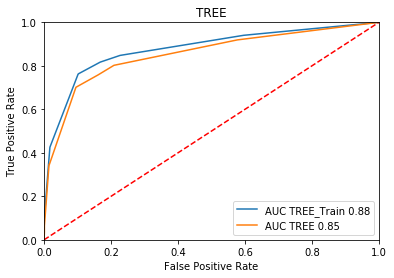

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.8726929530201343
TREE  =  0.8515100671140939
------




In [23]:
# Default PROBABILITY

WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth=4 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

feature_cols = list( X.columns.values )
tree.export_graphviz(CLM,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )
vars_tree_flag = getTreeVars( CLM, feature_cols ) 

In [24]:
for i in X.columns:
    if X[i].isna().sum() > 0 : print(i)

In [25]:
# Default amount

AMT = tree.DecisionTreeRegressor( max_depth= 4 )
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols ) 
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )


TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

TREE RMSE ACCURACY
TREE_Train  =  4603.091178678556
TREE  =  5770.601714157058
------




#### Random Forest

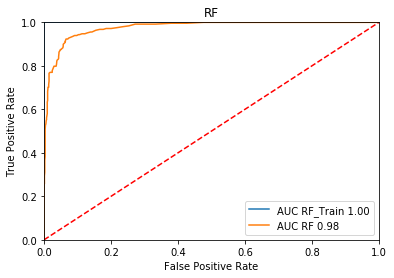

RF CLASSIFICATION ACCURACY
RF_Train  =  1.0
RF  =  0.927013422818792
------




In [26]:
WHO = "RF"

CLM = RandomForestClassifier( n_estimators=145, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )

In [27]:
# Default Amount

AMT = RandomForestRegressor(n_estimators = 145, random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

##for i in vars_RF_amt :
##    print( i )

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

RF RMSE ACCURACY
RF_Train  =  1382.964459193578
RF  =  3770.8264515729347
------




#### Gradient Boosting

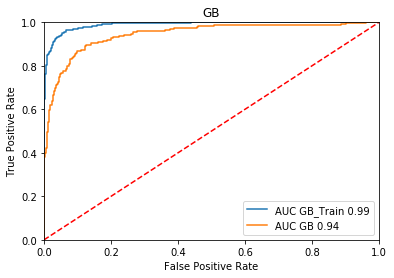

GB CLASSIFICATION ACCURACY
GB_Train  =  0.9609899328859061
GB  =  0.9060402684563759
------




In [28]:
WHO = "GB"

CLM = GradientBoostingClassifier(n_estimators=305, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )

In [29]:
# Default Amount

AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

##for i in vars_RF_amt :
##    print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

GB RMSE ACCURACY
GB_Train  =  1397.895815964368
GB  =  3006.3484671784527
------




# Now that we have the variables we will build Linear and Logistic Regression Models

In [30]:
# The below functions will be used for the linear and logistic regression models to get the coefficients


def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nDefault")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )



def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nAmount")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

## First model will leverage all variables

#### Logistic

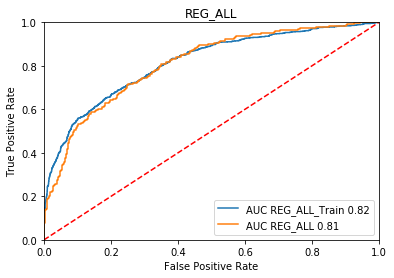

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.8475251677852349
REG_ALL  =  0.8162751677852349
------




In [31]:
WHO = "REG_ALL"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Linear

In [32]:
AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


varNames = list( X_train.columns.values )

REG_ALL_CLM_COEF = getCoefLogit( CLM, X_train )
REG_ALL_AMT_COEF = getCoefLinear( AMT, X_train )

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()

REG_ALL RMSE ACCURACY
REG_ALL_Train  =  4311.306992349995
REG_ALL  =  4561.9550473980025
------



Default
---------
Total Variables:  38
INTERCEPT  =  -2.418835227473071
z_REASON_DebtCon  =  -0.514116660747376
z_REASON_HomeImp  =  -0.23501713228384413
z_JOB_Mgr  =  0.5320529776071231
z_JOB_Office  =  -0.13108304446211952
z_JOB_Other  =  0.5469126721915706
z_JOB_ProfExe  =  0.4544730216768988
z_JOB_Sales  =  1.3601911472594679
z_JOB_Self  =  0.9303644687548721
O_LOAN  =  -0.09818545946089585
TRUNC_LOAN  =  -1.8584292995305803e-05
O_MORTDUE  =  -0.21436730314781163
O_VALUE  =  0.6713535651926101
O_YOJ  =  0.47510581160461207
O_DEROG  =  0.19761443328823947
O_DELINQ  =  0.9381451599545788
O_CLAGE  =  -0.35977749691089833
O_NINQ  =  -0.2199859373387901
O_CLNO  =  0.33136310635615474
O_DEBTINC  =  1.2681878663266306
O_IMP_MORTDUE  =  0.2568366725061356
TRUNC_IMP_MORTDUE  =  -4.028728136443035e-06
O_IMP_VALUE  =  0.6713535651926101
TRUNC_IMP_VALUE  =  5.44867611323714e-07
O_IMP_YOJ  =  0.44

## Variables Selected by the Decision Tree

#### Logistic

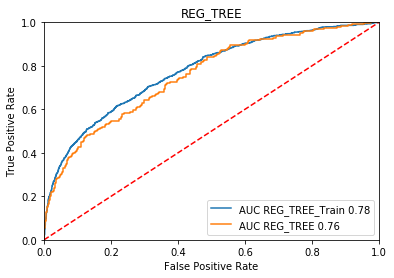

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8330536912751678
REG_TREE  =  0.8162751677852349
------




In [33]:
WHO = "REG_TREE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[vars_tree_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Linear

In [34]:
AMT = LinearRegression()
AMT = AMT.fit( W_train[vars_tree_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[vars_tree_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[vars_tree_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


varNames = list( X_train.columns.values )

REG_TREE_CLM_COEF = getCoefLogit( CLM, X_train[vars_tree_flag] )
REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt] )

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()

REG_TREE RMSE ACCURACY
REG_TREE_Train  =  5040.866153823822
REG_TREE  =  5865.435239762463
------



Default
---------
Total Variables:  6
INTERCEPT  =  -2.9517639314134554
TRUNC_IMP_NINQ  =  0.2150286498499407
TRUNC_IMP_DEBTINC  =  0.06323995693544353
TRUNC_IMP_VALUE  =  -2.305308943669697e-06
TRUNC_IMP_DELINQ  =  0.8330806529574075
TRUNC_IMP_CLAGE  =  -0.006810169486522394

Amount
---------
Total Variables:  7
INTERCEPT  =  -11166.865560159975
z_REASON_DebtCon  =  1678.2376860163338
TRUNC_IMP_CLNO  =  218.85724988484304
TRUNC_IMP_DEBTINC  =  157.357589025509
TRUNC_LOAN  =  0.73216009288433
TRUNC_IMP_MORTDUE  =  -0.0009630634221308153
TRUNC_IMP_DELINQ  =  1049.3434719988672


## Variables Selected by the Random Forest

#### Logistic




('TRUNC_IMP_DEBTINC', 100)
('TRUNC_IMP_CLAGE', 49)
('TRUNC_LOAN', 46)
('TRUNC_IMP_VALUE', 43)
('TRUNC_IMP_MORTDUE', 39)
('TRUNC_IMP_CLNO', 39)
('TRUNC_IMP_DELINQ', 38)
('TRUNC_IMP_YOJ', 30)
('TRUNC_IMP_DEROG', 23)
('TRUNC_IMP_NINQ', 22)



('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 13)
('TRUNC_IMP_DEBTINC', 9)
('TRUNC_IMP_CLAGE', 3)


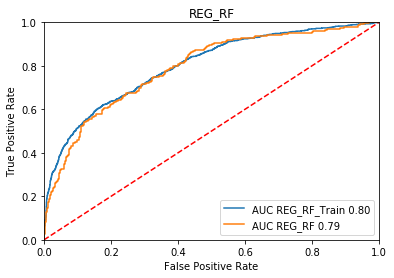

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8399748322147651
REG_RF  =  0.8204697986577181
------




In [35]:

WHO = "REG_RF"


print("\n\n")
RF_flag = []
for i in vars_RF_flag :
    print(i)
    theVar = i[0]
    RF_flag.append( theVar )

print("\n\n")
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[RF_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Linear

In [36]:
AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )
REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()

REG_RF RMSE ACCURACY
REG_RF_Train  =  4996.859723021498
REG_RF  =  5687.399121822825
------



Default
---------
Total Variables:  11
INTERCEPT  =  -2.9914943271919068
TRUNC_IMP_DEBTINC  =  0.07045817818064438
TRUNC_IMP_CLAGE  =  -0.005727582700852873
TRUNC_LOAN  =  -1.825757850955077e-05
TRUNC_IMP_VALUE  =  2.2553340213993666e-06
TRUNC_IMP_MORTDUE  =  -3.2250090301923336e-06
TRUNC_IMP_CLNO  =  -0.018060225543754437
TRUNC_IMP_DELINQ  =  0.7981872346456573
TRUNC_IMP_YOJ  =  -0.006617518538102379
TRUNC_IMP_DEROG  =  0.7646759200375735
TRUNC_IMP_NINQ  =  0.19573357161018598

Amount
---------
Total Variables:  5
INTERCEPT  =  -5724.454099611805
TRUNC_LOAN  =  0.7694375551446857
TRUNC_IMP_CLNO  =  309.7546662874566
TRUNC_IMP_DEBTINC  =  99.00902866731356
TRUNC_IMP_CLAGE  =  -25.356816274303533


## Variables Selected by the Gradient Boosting

#### Logistic




('TRUNC_IMP_DEBTINC', 100)
('TRUNC_IMP_DELINQ', 26)
('TRUNC_IMP_CLAGE', 18)
('TRUNC_IMP_VALUE', 12)
('TRUNC_IMP_DEROG', 10)
('TRUNC_IMP_CLNO', 10)
('TRUNC_LOAN', 9)
('TRUNC_IMP_MORTDUE', 8)
('TRUNC_IMP_YOJ', 7)



('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 15)
('TRUNC_IMP_DEBTINC', 11)
('TRUNC_IMP_CLAGE', 4)


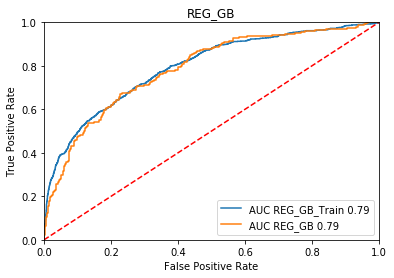

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.8406040268456376
REG_GB  =  0.8154362416107382
------




In [37]:
WHO = "REG_GB"


print("\n\n")
GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append( theVar )

print("\n\n")
GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[GB_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Linear

In [38]:
AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )
REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )

REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()

REG_GB RMSE ACCURACY
REG_GB_Train  =  4996.859723021498
REG_GB  =  5687.399121822825
------



Default
---------
Total Variables:  10
INTERCEPT  =  -2.9081673847470784
TRUNC_IMP_DEBTINC  =  0.07451009265969581
TRUNC_IMP_DELINQ  =  0.7950302983793213
TRUNC_IMP_CLAGE  =  -0.006109629469100636
TRUNC_IMP_VALUE  =  1.6674740291261645e-06
TRUNC_IMP_DEROG  =  0.8135848896737449
TRUNC_IMP_CLNO  =  -0.014389393516553047
TRUNC_LOAN  =  -1.5036499897923986e-05
TRUNC_IMP_MORTDUE  =  -2.9538819419571902e-06
TRUNC_IMP_YOJ  =  -0.008747873075336202

Amount
---------
Total Variables:  5
INTERCEPT  =  -5724.454099611805
TRUNC_LOAN  =  0.7694375551446857
TRUNC_IMP_CLNO  =  309.7546662874566
TRUNC_IMP_DEBTINC  =  99.00902866731356
TRUNC_IMP_CLAGE  =  -25.356816274303533


## Regression Stepwise Selection

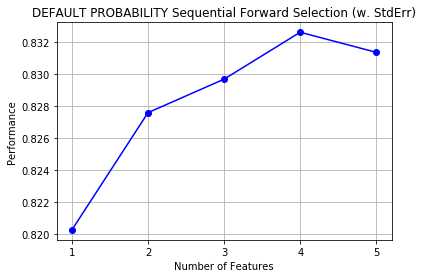

 ................... 
argmax
feature_names    (0, 1, 3, 4)
avg_score            0.832634
Name: 4, dtype: object
 ................... 
('0', '1', '3', '4')
TRUNC_IMP_NINQ
TRUNC_IMP_DEBTINC
TRUNC_IMP_DELINQ
TRUNC_IMP_CLAGE


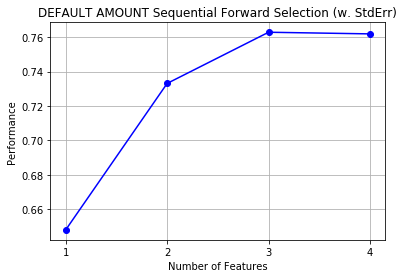

 ................... 
argmax
feature_names    (0, 1, 3)
avg_score          0.76294
Name: 3, dtype: object
 ................... 
('0', '1', '3')
TRUNC_LOAN
TRUNC_IMP_CLNO
TRUNC_IMP_CLAGE


In [39]:
U_train = X_train[ vars_tree_flag ]
stepVarNames = list( U_train.columns.values )
maxCols = U_train.shape[1]

sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=100 ),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           cv=3
           )
sfs.fit(U_train.values, Y_train[ TARGET_F ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('DEFAULT PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

U_train = X_train[ finalStepVars ]
U_test = X_test[ finalStepVars ]



V_train = W_train[ GB_amt ]
stepVarNames = list( V_train.columns.values )
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv=5
           )
sfs.fit(V_train.values, Z_train[ TARGET_A ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('DEFAULT AMOUNT Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

V_train = W_train[ finalStepVars ]
V_test = W_test[ finalStepVars ]

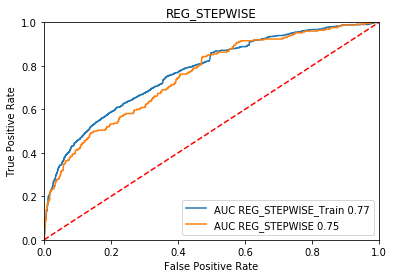

REG_STEPWISE CLASSIFICATION ACCURACY
REG_STEPWISE_Train  =  0.8326342281879194
REG_STEPWISE  =  0.8179530201342282
------


REG_STEPWISE RMSE ACCURACY
REG_STEPWISE_Train  =  5036.799121185126
REG_STEPWISE  =  5760.055039945557
------



Default
---------
Total Variables:  5
INTERCEPT  =  -3.063970947572953
TRUNC_IMP_NINQ  =  0.2152480729224489
TRUNC_IMP_DEBTINC  =  0.06155629734398741
TRUNC_IMP_DELINQ  =  0.8361349049078596
TRUNC_IMP_CLAGE  =  -0.007153101382043059

Amount
---------
Total Variables:  4
INTERCEPT  =  -2220.1532114325255
TRUNC_LOAN  =  0.7709354550976218
TRUNC_IMP_CLNO  =  319.7463105675468
TRUNC_IMP_CLAGE  =  -26.59313420314479


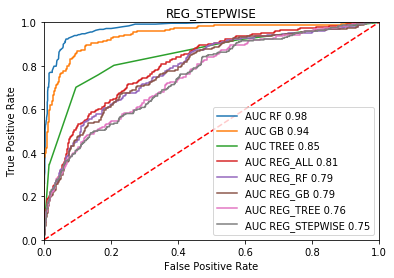

ALL CLASSIFICATION ACCURACY
RF  =  0.927013422818792
GB  =  0.9060402684563759
TREE  =  0.8515100671140939
REG_RF  =  0.8204697986577181
REG_STEPWISE  =  0.8179530201342282
REG_ALL  =  0.8162751677852349
REG_TREE  =  0.8162751677852349
REG_GB  =  0.8154362416107382
------


ALL DEFAULT MODEL ACCURACY
GB  =  3006.3484671784527
RF  =  3770.8264515729347
REG_ALL  =  4561.9550473980025
REG_RF  =  5687.399121822825
REG_GB  =  5687.399121822825
REG_STEPWISE  =  5760.055039945557
TREE  =  5770.601714157058
REG_TREE  =  5865.435239762463
------




In [43]:
WHO = "REG_STEPWISE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( U_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( V_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_STEP_CLM_COEF = getCoefLogit( CLM, U_train )
REG_STEP_AMT_COEF = getCoefLinear( AMT, V_train )

REG_STEP_CLM = TEST_CLM.copy()
REG_STEP_AMT = TEST_AMT.copy()






# Create a list of models
ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, REG_GB_CLM, REG_STEP_CLM ]

# Sort these guys by the fourth element in the list which is AUC
# Sort a lists of lists and don't want to go by the first element in the list
ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

# get the accuracy of the damages and sort those as well
ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )


ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL DEFAULT MODEL ACCURACY", ALL_AMT )

# Comments on results will be in attached PDF write-up